In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

import os
import zipfile

local_zip = '/home/srijan/Downloads/Dataset-20200512T115103Z-001.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/home/srijan/Downloads')
zip_ref.close()

--2020-05-13 11:26:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:810::2010, 216.58.203.48
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:810::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   134KB/s    in 16m 27s 

2020-05-13 11:43:20 (87.0 KB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [2]:
base_dir = '/home/srijan/Downloads/Dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_no_spill_dir = os.path.join(train_dir, 'no spill images train')
train_spill_dir = os.path.join(train_dir, 'spill images train')

# Directory with our validation cat/dog pictures
validation_no_spill_dir = os.path.join(validation_dir, 'no spill images test')
validation_spill_dir = os.path.join(validation_dir, 'spill images test')


In [3]:
train_no_spill_fnames = os.listdir( train_no_spill_dir )
train_spill_fnames = os.listdir( train_spill_dir )

print(train_no_spill_fnames[:10])
print(train_spill_fnames[:10])

['IMG_20191204_115352.jpg', 'IMG_20191204_114329.jpg', 'IMG_20191204_153843.jpg', 'IMG_20191204_114135.jpg', 'IMG_20191204_153141.jpg', 'IMG_20191204_153904.jpg', 'IMG_20191204_115327.jpg', 'IMG_20191204_153924.jpg', 'IMG_20191204_115424.jpg', 'IMG_20191204_152945.jpg']
['IMG_20191204_153532.jpg', 'IMG_20191204_114749.jpg', 'IMG_20191204_154320.jpg', 'IMG_20191204_115903.jpg', 'IMG_20191204_154245.jpg', 'IMG_20191204_120742.jpg', 'IMG_20191204_153610.jpg', 'IMG_20191204_120531.jpg', 'IMG_20191204_120631.jpg', 'IMG_20191204_114625.jpg']


In [4]:
print('total training no_spill images :', len(os.listdir(      train_no_spill_dir ) ))
print('total training spill images :', len(os.listdir(      train_spill_dir ) ))

print('total validation no_spill images :', len(os.listdir( validation_no_spill_dir ) ))
print('total validation spill images :', len(os.listdir( validation_spill_dir ) ))

total training no spill images : 47
total training spill images : 50
total validation no spill images : 10
total validation spill images : 11


In [5]:
import tensorflow as tf

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=7,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 97 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [31]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=5,
                              epochs=25,
                              validation_steps=3,
                              verbose=2)

Epoch 1/25
5/5 - 22s - loss: 0.1315 - accuracy: 0.9691 - val_loss: 3.7870 - val_accuracy: 0.5238
Epoch 2/25
5/5 - 22s - loss: 0.0469 - accuracy: 0.9897 - val_loss: 0.7435 - val_accuracy: 0.8095
Epoch 3/25
5/5 - 22s - loss: 0.0890 - accuracy: 0.9588 - val_loss: 1.3091 - val_accuracy: 0.7619
Epoch 4/25
5/5 - 22s - loss: 0.0142 - accuracy: 0.9897 - val_loss: 3.0247 - val_accuracy: 0.6190
Epoch 5/25
5/5 - 23s - loss: 0.1415 - accuracy: 0.9588 - val_loss: 1.6089 - val_accuracy: 0.8095
Epoch 6/25
5/5 - 22s - loss: 0.0616 - accuracy: 0.9588 - val_loss: 3.6762 - val_accuracy: 0.5238
Epoch 7/25
5/5 - 22s - loss: 0.1929 - accuracy: 0.9381 - val_loss: 3.0063 - val_accuracy: 0.6190
Epoch 8/25
5/5 - 23s - loss: 0.2408 - accuracy: 0.9691 - val_loss: 4.8212 - val_accuracy: 0.5238
Epoch 9/25
5/5 - 23s - loss: 0.6457 - accuracy: 0.9175 - val_loss: 3.8075 - val_accuracy: 0.5238
Epoch 10/25
5/5 - 23s - loss: 0.0688 - accuracy: 0.9794 - val_loss: 2.2489 - val_accuracy: 0.6667
Epoch 11/25
5/5 - 22s - loss:

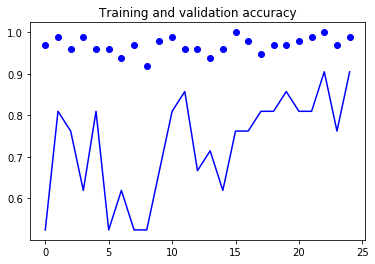

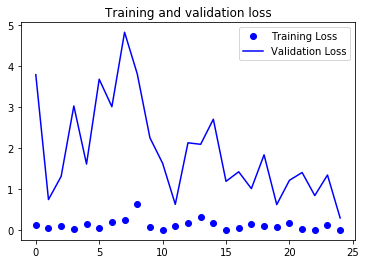

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()